In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/sf-dl-nucleus-detection/sample_submission.csv
/kaggle/input/sf-dl-nucleus-detection/train.zip
/kaggle/input/sf-dl-nucleus-detection/test.zip
/kaggle/input/sf-dl-nucleus-detection/train_labels.csv


In [2]:
import os
import zipfile
import pandas as pd
import numpy as np
import skimage
import skimage.io 
import albumentations
import matplotlib.pyplot as plt
import keras
import tensorflow as tf
import random

In [3]:
TRAIN_PATH = '../input/sf-dl-nucleus-detection/train.zip'
TEST_PATH = '../input/sf-dl-nucleus-detection/test.zip'
TRAIN_LEBELS = '../input/sf-dl-nucleus-detection/train_labels.csv'

IMG_WIDTH = 256
IMG_HEIGHT  = 256
IMG_CHANNELS = 3

SEED = 42
BATCH_SIZE = 32 #?
NUM_EPOCHS = 70
LEARNING_RATE = 0.001
TRAIN_TEST_SPLIT = 0.1

In [4]:
transform_1 = albumentations.Compose([albumentations.HorizontalFlip(p=1)])
transform_2 = albumentations.Compose([albumentations.VerticalFlip(p=1)])

In [5]:
def repack(name_data):
    if not os.path.exists('./'+name_data+'/'):
        tmp_zip = zipfile.ZipFile('../input/sf-dl-nucleus-detection/'+name_data+'.zip')
        tmp_zip.extractall(name_data)
        tmp_zip.close()


In [6]:
repack('train')
repack('test')

In [7]:
sample_submission = pd.read_csv('../input/sf-dl-nucleus-detection/train_labels.csv')
train_labels = pd.read_csv('../input/sf-dl-nucleus-detection/train_labels.csv')

In [8]:
print(len(train_labels))
print(len(train_labels['ImageId'].unique()))

29461
670


In [9]:
def get_X_data(path, output_shape=(None, None)):
    img_paths = ['{0}/{1}/images/{1}.png'.format(path, id) for id in os.listdir(path)]
    X_data = np.array([skimage.transform.resize(skimage.io.imread(path)[:,:,:3], 
                                                output_shape=output_shape, 
                                                mode='constant', 
                                                preserve_range=True) for path in img_paths], dtype=np.uint8)  #take only 3 channels/bands
    
    return X_data

In [10]:
def get_Y_data(path, output_shape=(None, None)):
    img_paths = ['{0}/{1}/masks/*.png'.format(path, id) for id in os.listdir(path)]
    
    Y_data = []
    for i, img_masks in enumerate(img_paths):  #loop through each individual nuclei for an image and combine them together
        masks = skimage.io.imread_collection(img_masks).concatenate()  #masks.shape = (num_masks, img_height, img_width)
        mask = np.max(masks, axis=0)                                   #mask.shape = (img_height, img_width)
        mask = skimage.transform.resize(mask, output_shape=output_shape+(1,), mode='constant', preserve_range=True)  #need to add an extra dimension so mask.shape = (img_height, img_width, 1)
        Y_data.append(mask)
    Y_data = np.array(Y_data,dtype = np.bool)
    
    return Y_data

In [11]:
def trans(img,transforms):
    temp=transforms(image=img)
    temp=temp['image']
    return temp

In [12]:
X_train = get_X_data('train/', output_shape=(IMG_HEIGHT,IMG_WIDTH))
Y_train = get_Y_data('train/', output_shape=(IMG_HEIGHT,IMG_WIDTH))

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # Remove the CWD from sys.path while we load stuff.


In [13]:
print(len(X_train))
print(len(Y_train))

670
670


In [14]:
X=np.array([trans(xi,transform_1) for xi in X_train])
Y=np.array([trans(xi,transform_1) for xi in Y_train])

X_train=np.vstack((X_train, X))
Y_train=np.vstack((Y_train, Y))

X=np.array([trans(xi,transform_2) for xi in X_train])
Y=np.array([trans(xi,transform_2) for xi in Y_train])

X_train=np.vstack((X_train, X))
Y_train=np.vstack((Y_train, Y))

In [15]:
print(len(X_train))
print(len(Y_train))

2680
2680


1591


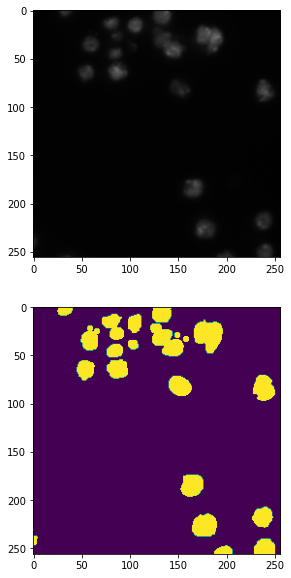

In [16]:
f, axarr = plt.subplots(2,1)
f.set_size_inches(20,10)
ix = random.randint(0, len(X_train))
print(ix)
axarr[0].imshow(X_train[ix])
axarr[1].imshow(np.squeeze(Y_train[ix]))

plt.show()

In [17]:
Y_train[ix]

array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])

# MODEL

In [18]:
inputs = keras.layers.Input((IMG_WIDTH, IMG_HEIGHT, IMG_CHANNELS))
s = keras.layers.Lambda(lambda x: x / 255) (inputs)
c1 = keras.layers.Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (s)
c1 = keras.layers.Dropout(0.1) (c1)
c1 = keras.layers.Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c1)
p1 = keras.layers.MaxPooling2D((2, 2)) (c1)

c2 = keras.layers.Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p1)
c2 = keras.layers.Dropout(0.1) (c2)
c2 = keras.layers.Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c2)
p2 = keras.layers.MaxPooling2D((2, 2)) (c2)

c3 = keras.layers.Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p2)
c3 = keras.layers.Dropout(0.2) (c3)
c3 = keras.layers.Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c3)
p3 = keras.layers.MaxPooling2D((2, 2)) (c3)

c4 = keras.layers.Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p3)
c4 = keras.layers.Dropout(0.2) (c4)
c4 = keras.layers.Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c4)
p4 = keras.layers.MaxPooling2D(pool_size=(2, 2)) (c4)

c5 = keras.layers.Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p4)
c5 = keras.layers.BatchNormalization() (c5)
c5 = keras.layers.Dropout(0.3) (c5)
c5 = keras.layers.Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c5)

u6 = keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = keras.layers.concatenate([u6, c4])
c6 = keras.layers.Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u6)
c6 = keras.layers.Dropout(0.2) (c6)
c6 = keras.layers.Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c6)

u7 = keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = keras.layers.concatenate([u7, c3])
c7 = keras.layers.Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u7)
c7 = keras.layers.Dropout(0.2) (c7)
c7 = keras.layers.Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c7)

u8 = keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = keras.layers.concatenate([u8, c2])
c8 = keras.layers.Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u8)
c8 = keras.layers.Dropout(0.1) (c8)
c8 = keras.layers.Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c8)

u9 = keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = keras.layers.concatenate([u9, c1], axis=3)
c9 = keras.layers.Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u9)
c9 = keras.layers.Dropout(0.1) (c9)
c9 = keras.layers.Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c9)

outputs = keras.layers.Conv2D(1, (1, 1), activation='sigmoid') (c9)

model = keras.models.Model(inputs=[inputs], outputs=[outputs])
optimizer = tf.keras.optimizers.Adam(learning_rate = LEARNING_RATE)
model.compile(optimizer=optimizer, loss='binary_crossentropy',)
model.summary()

2022-07-01 13:48:17.608204: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-01 13:48:17.731783: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-01 13:48:17.732847: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-01 13:48:17.734389: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 256, 256, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 16) 448         lambda[0][0]                     
__________________________________________________________________________________________________
dropout (Dropout)               (None, 256, 256, 16) 0           conv2d[0][0]                     
______________________________________________________________________________________________

# TRAIN

In [19]:
history = model.fit(X_train,
          Y_train,
          validation_split = TRAIN_TEST_SPLIT,
          batch_size=BATCH_SIZE, 
          epochs=NUM_EPOCHS, 
          verbose=1)

2022-07-01 13:48:22.097289: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/70


2022-07-01 13:48:24.639110: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


76/76 [==============================] - 22s 169ms/step - loss: 0.1904 - val_loss: 0.1325
Epoch 2/70
76/76 [==============================] - 12s 154ms/step - loss: 0.1017 - val_loss: 0.0869
Epoch 3/70
76/76 [==============================] - 12s 154ms/step - loss: 0.0837 - val_loss: 0.0835
Epoch 4/70
76/76 [==============================] - 12s 154ms/step - loss: 0.0806 - val_loss: 0.0771
Epoch 5/70
76/76 [==============================] - 12s 154ms/step - loss: 0.0753 - val_loss: 0.0728
Epoch 6/70
76/76 [==============================] - 12s 154ms/step - loss: 0.0738 - val_loss: 0.0713
Epoch 7/70
76/76 [==============================] - 12s 154ms/step - loss: 0.0715 - val_loss: 0.0687
Epoch 8/70
76/76 [==============================] - 12s 154ms/step - loss: 0.0695 - val_loss: 0.0724
Epoch 9/70
76/76 [==============================] - 12s 154ms/step - loss: 0.0789 - val_loss: 0.0706
Epoch 10/70
76/76 [==============================] - 12s 154ms/step - loss: 0.0712 - val_loss: 0.0655


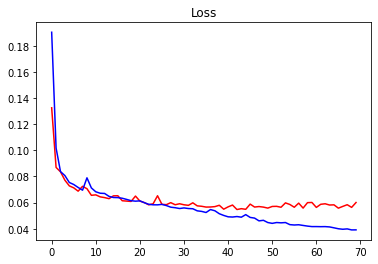

In [20]:
def plot_loss_history(history):
    # validation losses
    val_loss = history.history['val_loss']
    loss = history.history['loss']

    plt.title('Loss')
    plt.plot(val_loss, 'r', loss, 'b')
    plt.show()
    
plot_loss_history(history)

In [21]:
MODEL_NAME = 'keras_unet.h5'

In [22]:
model.save(MODEL_NAME)

# PREDICT

In [23]:
model = keras.models.load_model(MODEL_NAME,)

In [24]:
X_test = get_X_data('test/', output_shape=(IMG_HEIGHT,IMG_WIDTH))
Y_hat =  model.predict(X_test, verbose=1)

3/3 [==============================] - 1s 115ms/step


15


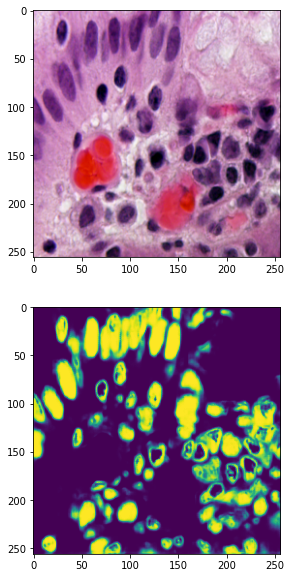

In [25]:
f, axarr = plt.subplots(2,1)
f.set_size_inches(20,10)
ix = random.randint(0, len(X_test))
print(ix)
axarr[0].imshow(X_test[ix])
axarr[1].imshow(np.squeeze(Y_hat[ix]))

plt.show()


In [26]:
def rle_encoding(x):
    dots = np.where(x.T.flatten() == 1)[0]
    run_lengths = []
    prev = -2
    for b in dots:
        if (b>prev+1): run_lengths.extend((b + 1, 0))
        run_lengths[-1] += 1
        prev = b
    return run_lengths

def prob_to_rles(x, cutoff=0.5):
    lab_img = skimage.morphology.label(x > cutoff)
    for i in range(1, lab_img.max() + 1):
        yield rle_encoding(lab_img == i)

In [27]:
# Upsample Y_hat back to the original X_test size (height and width)
Y_hat_upsampled = []
for i, test_id in enumerate(os.listdir('./test')):  #loop through test_ids in the test_path
    img = skimage.io.imread('{0}/{1}/images/{1}.png'.format(TEST_PATH, test_id))  #read original test image directly from path
    img_upscaled = skimage.transform.resize(Y_hat[i], (img.shape[0], img.shape[1]), mode='constant', preserve_range=True)  #upscale Y_hat image according to original test image
    Y_hat_upsampled.append(img_upscaled)   #append upscaled image to Y_hat_upsampled
len(Y_hat_upsampled)

65

In [28]:
# Apply Run-Length Encoding on our Y_hat_upscaled
new_test_ids = []
rles = []
for n, id_ in enumerate(os.listdir('./test')):
    rle = list(prob_to_rles(Y_hat_upsampled[n]))
    rles.extend(rle)
    new_test_ids.extend([id_] * len(rle))
len(new_test_ids)  #note that for each test_image, we can have multiple entries of encoded pixels

2575

In [29]:
# Create submission DataFrame
sub = pd.DataFrame()
sub['ImageId'] = new_test_ids
sub['EncodedPixels'] = pd.Series(rles).apply(lambda x: ' '.join(str(y) for y in x))
sub.to_csv('./submission.csv', index=False)